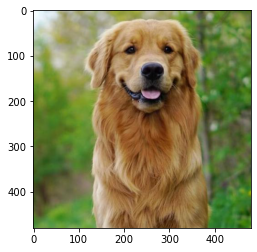

In [1]:
import torchvision.models as models
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from torchvision import transforms
from PIL import Image
from matplotlib.pyplot import imshow

torch.manual_seed(123)
# the model we want to break
alexnet = models.alexnet(pretrained=True)
model = alexnet

# Read RGB image

filename = "golden_retriever.jpg" #"tissue.jpeg"

# sample execution (requires torchvision)
input_image = Image.open(filename)
imshow(np.asarray(input_image))

In [2]:

def process_img(pil_img):
    # preprocess the image and feed to model
    preprocess = transforms.Compose([
        transforms.Resize((224,224)), # 256
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(pil_img)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    
    return input_batch

# transform a tensor to pil image
def reverse_process(img_tensor):
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                                ])

    img_tensor = invTrans(img_tensor)

    im = transforms.ToPILImage()(img_tensor.squeeze(0)).convert("RGB")
    return im

input_batch = process_img(input_image)
original_image = reverse_process(input_batch)

# class for noise
# is a tensor of size (3 x 224 x 224)
class Noise(nn.Module):
    def __init__(self, h=224, w=224, c=3):
        super().__init__()
        self.noise = nn.Parameter(torch.zeros((1, c, h, w)))
    
    def forward(self, img):
        return self.noise + img

noise = Noise()


target = torch.tensor([2]) # target class "great white shark"

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')
    noise.to('cuda')
    target = target.to('cuda')

# loss function to train noise
celoss = nn.CrossEntropyLoss()
# optimizer to train noise
optimizer = optim.SGD(noise.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

# training loop:

def train_noise(n=1000):
    for _ in range(n):
    #with torch.no_grad():
        # clear grad
        optimizer.zero_grad()
        # feed to the model
        output = model(noise(input_batch))
        # compute loss
        loss = celoss(output, target)
        # perform backprob
        loss.backward()
        # update noise
        optimizer.step()

def predict(input_, add_noise=False):
    with torch.no_grad():
        if add_noise:
            output = model(noise(input_))
        else:
            output = model(input_)
        # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
    with open("imagenet.txt", "r") as f: # open the class file
        categories = [s.strip() for s in f.readlines()]
    # Show top categories of prediction per image
    print("====Top 5 predictions, noised={}:".format(add_noise))
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], "confidence: {:.2f}%".format(top5_prob[i].item() * 100))

predict(input_batch)
print("====Start training noise====")
train_noise()
print("====Done====")

====Top 5 predictions, noised=False:
golden retriever confidence: 98.87%
Sussex spaniel confidence: 0.51%
cocker spaniel confidence: 0.39%
tennis ball confidence: 0.11%
Tibetan mastiff confidence: 0.08%
====Start training noise====
====Done====


====Top 5 predictions, noised=False:
golden retriever confidence: 98.28%
Tibetan mastiff confidence: 0.83%
tennis ball confidence: 0.52%
Sussex spaniel confidence: 0.24%
redbone confidence: 0.05%


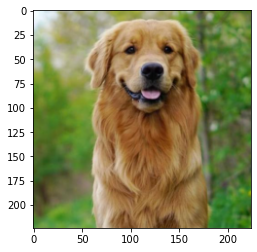

In [3]:
# show original image
imshow(np.asarray(original_image))
predict(input_batch)

In [4]:
# # TODO: show noise 
# imshow(noise.noise.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())

====Top 5 predictions, noised=True:
great white shark confidence: 98.56%
tiger shark confidence: 0.82%
birdhouse confidence: 0.11%
baseball confidence: 0.09%
rugby ball confidence: 0.05%


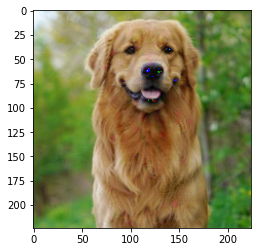

In [5]:
# show noised image
noised_image = reverse_process(noise(input_batch))
imshow(np.asarray(noised_image))
predict(input_batch, True)